In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
hudco_path = '/content/gdrive/My Drive/HUDCO.BO.csv'
federal_path = '/content/gdrive/My Drive/FEDERALBNK.NS.csv'  

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 4.2MB/s 
     |████████████████████████████████| 9.5MB 13.8MB/s 
     |████████████████████████████████| 2.1MB 44.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
hudco_data = pd.read_csv(hudco_path,sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(method = 'ffill')
federal_data = pd.read_csv(federal_path,sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(method = 'ffill')

In [ ]:
hudco_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-20,31.100000,31.750000,31.100000,31.299999,31.299999,51993.0
2020-10-21,31.299999,32.250000,31.000000,31.850000,31.850000,64254.0
2020-10-22,31.950001,33.799999,31.850000,33.500000,33.500000,92025.0
2020-10-23,34.200001,34.349998,33.049999,33.099998,33.099998,73456.0
2020-10-26,33.849998,33.849998,32.250000,32.549999,32.549999,62903.0
...,...,...,...,...,...,...
2021-01-13,42.700001,49.000000,42.700001,46.950001,46.950001,4156309.0
2021-01-14,46.900002,47.200001,45.400002,46.099998,46.099998,460033.0
2021-01-15,46.099998,46.200001,44.250000,44.700001,44.700001,262341.0


In [ ]:
federal_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-20,55.549999,57.200001,55.049999,56.849998,56.849998,46062002.0
2020-10-21,56.849998,58.799999,55.750000,57.000000,57.000000,54765746.0
2020-10-22,56.500000,56.849998,55.750000,56.500000,56.500000,32543391.0
2020-10-23,57.000000,57.150002,55.900002,56.000000,56.000000,27949393.0
2020-10-26,56.299999,56.299999,54.000000,54.150002,54.150002,32690654.0
...,...,...,...,...,...,...
2021-01-13,77.000000,78.000000,74.349998,74.800003,74.800003,41785200.0
2021-01-14,75.199997,75.900002,74.250000,75.050003,75.050003,21212153.0
2021-01-15,74.849998,75.300003,71.800003,73.349998,73.349998,28983879.0


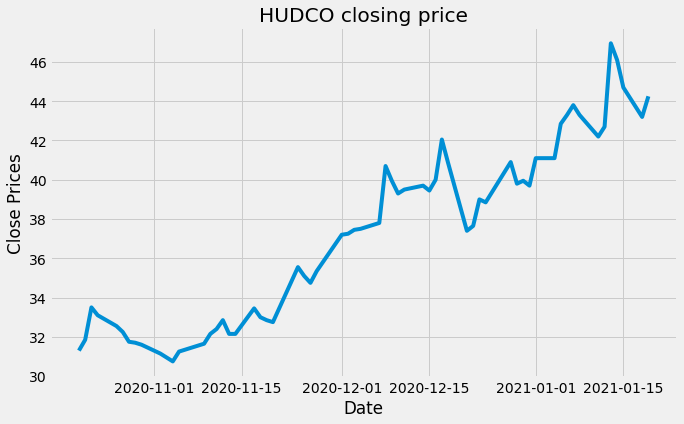

In [ ]:
#plot close price of HUDCO
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(hudco_data['Close'])
plt.title('HUDCO closing price')
plt.show()

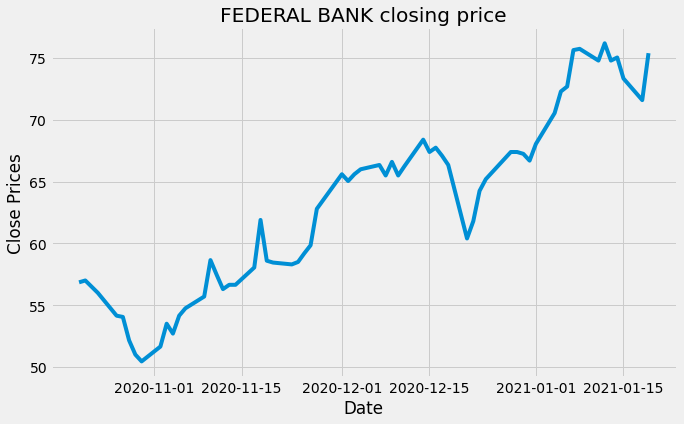

In [ ]:
#plot close price OF FEDERAL BANK
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(federal_data['Close'])
plt.title('FEDERAL BANK closing price')
plt.show()

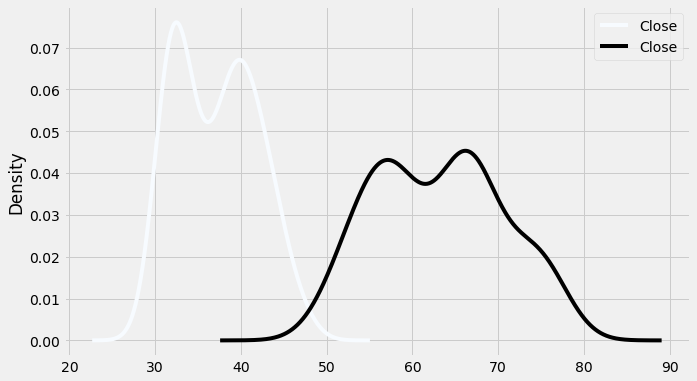

In [ ]:
#Distribution of the dataset
hudco_df_close = hudco_data['Close']
hudco_df_close.plot(kind='kde', colormap='Blues', legend=bool) 

fed_df_close = federal_data['Close']
fed_df_close.plot(kind='kde', colormap='copper', legend=bool) 

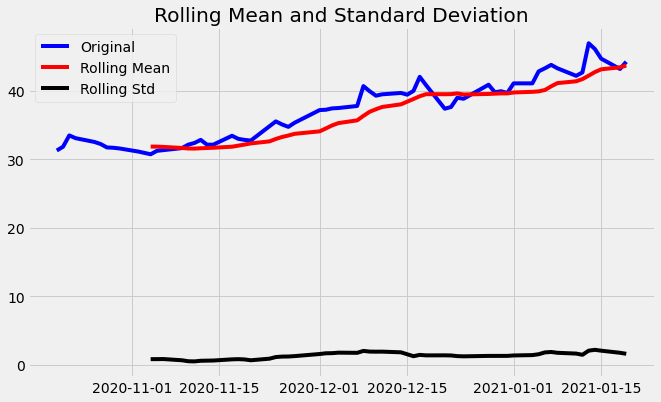

Results of dickey fuller test
Test Statistics                 0.360877
p-value                         0.979971
No. of lags used                3.000000
Number of observations used    60.000000
critical value (1%)            -3.544369
critical value (5%)            -2.911073
critical value (10%)           -2.593190
dtype: float64


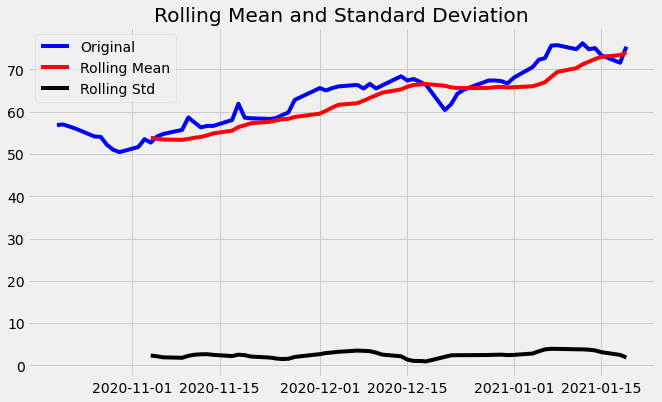

Results of dickey fuller test
Test Statistics                -0.319316
p-value                         0.922724
No. of lags used                0.000000
Number of observations used    63.000000
critical value (1%)            -3.538695
critical value (5%)            -2.908645
critical value (10%)           -2.591897
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(hudco_df_close) 
test_stationarity(fed_df_close) 

<Figure size 720x432 with 0 Axes>

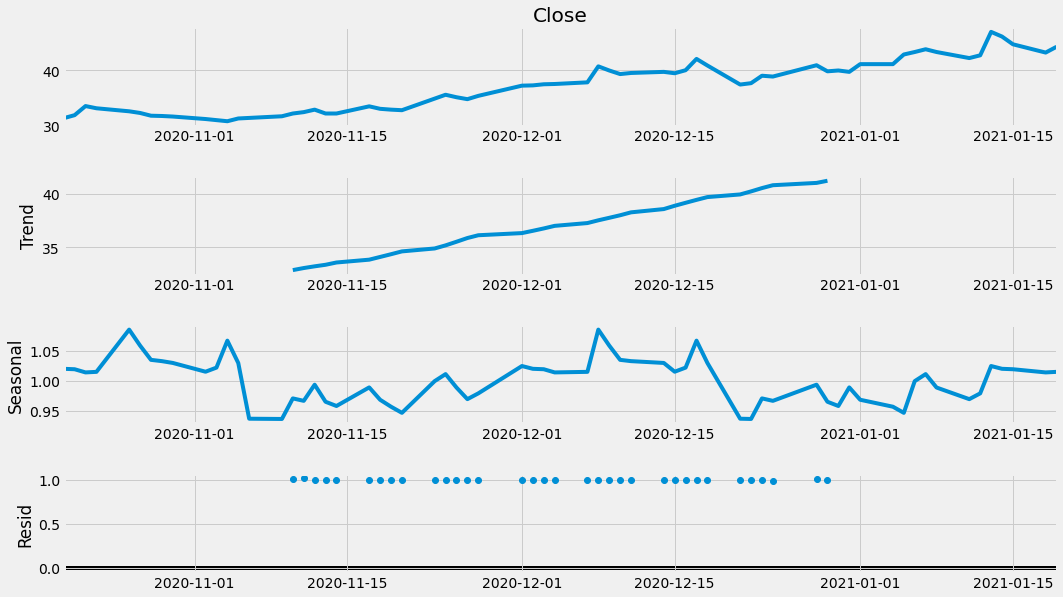

In [ ]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
hudco_df_close = hudco_data['Close']
result = seasonal_decompose(hudco_df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

<Figure size 720x432 with 0 Axes>

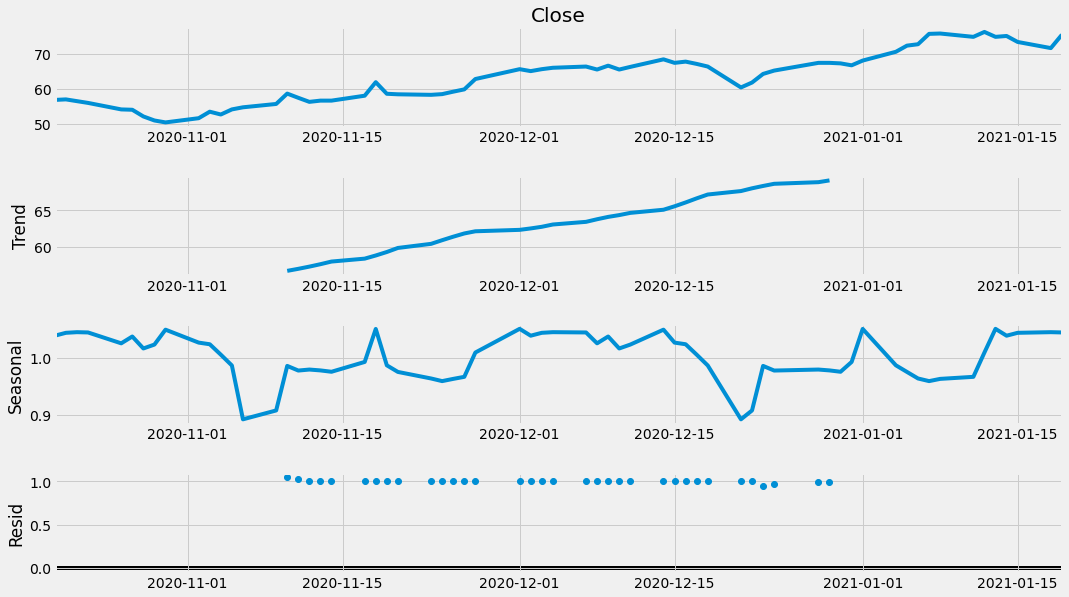

In [ ]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
hudco_df_close = federal_data['Close']
result = seasonal_decompose(fed_df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


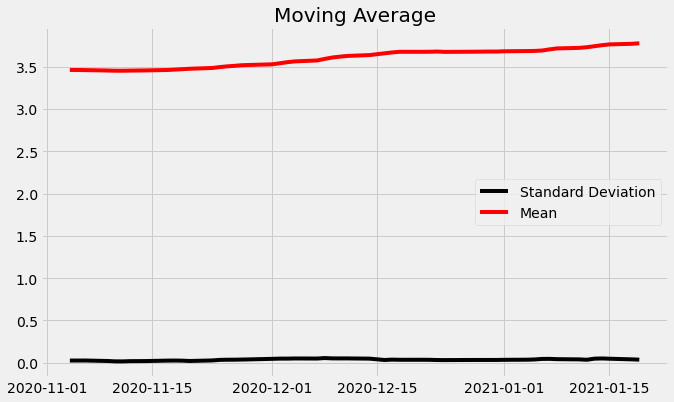

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(hudco_df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

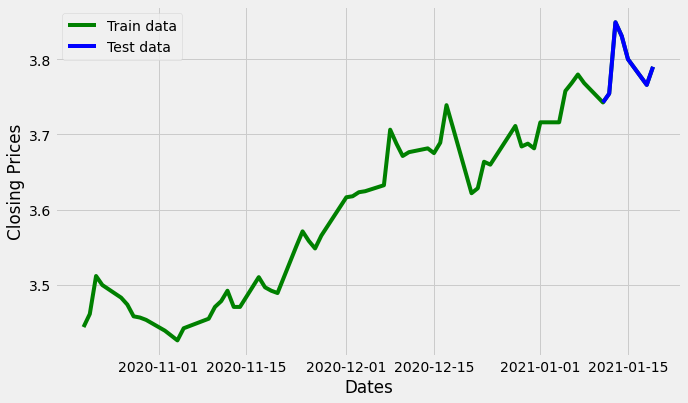

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-232.637, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-230.651, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-230.666, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-232.654, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-230.207, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.376 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 117.327
Date:                Wed, 20 Jan 2021   AIC                           -232.654
Time:                        09:35:14   BIC                           -230.684
Sample:                             0   HQIC                          -231.896
                                 - 54                                       

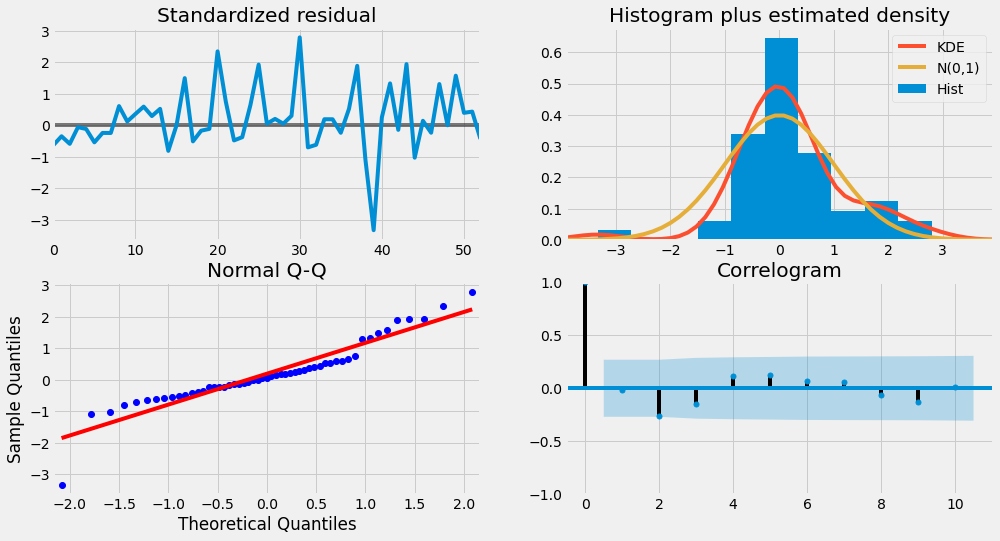

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                   53
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 120.166
Method:                       css-mle   S.D. of innovations              0.025
Date:                Wed, 20 Jan 2021   AIC                           -230.331
Time:                        09:35:49   BIC                           -220.480
Sample:                             1   HQIC                          -226.543
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0062      0.001      7.213      0.000       0.004       0.008
ar.L1.D.Close     0.7398      0.144      5.123      0.000       0.457       1.023
ma.L1.D.Close    -0.8308      0.203     

In [ ]:
# Forecast
fc, se, conf = fitted.forecast(7, alpha=0.05)  # 95% conf

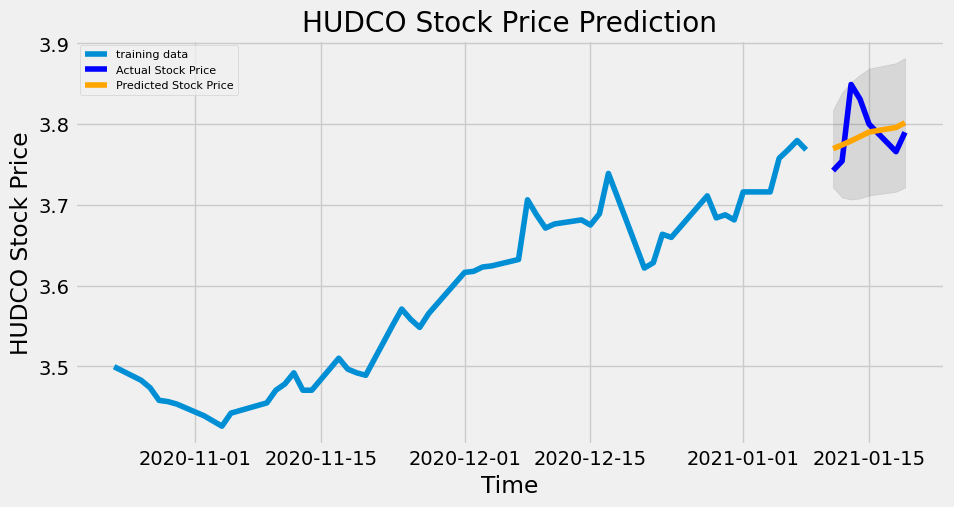

In [ ]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) 
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('HUDCO Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('HUDCO Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.001326905218104588
MAE: 0.03068644501088239
RMSE: 0.036426710228959575
MAPE: 0.008064133084882576


FEDERAL BANK

No handles with labels found to put in legend.


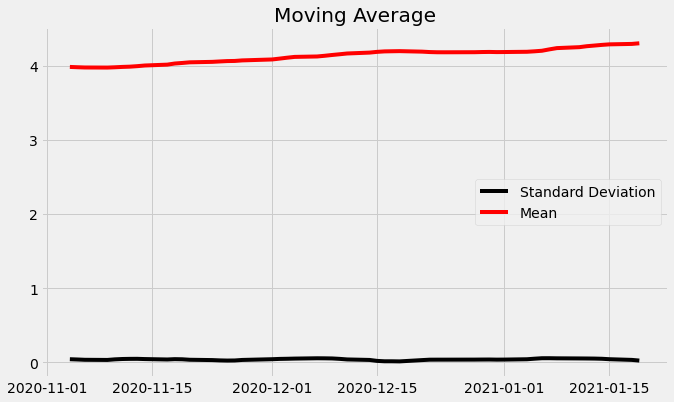

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(fed_df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

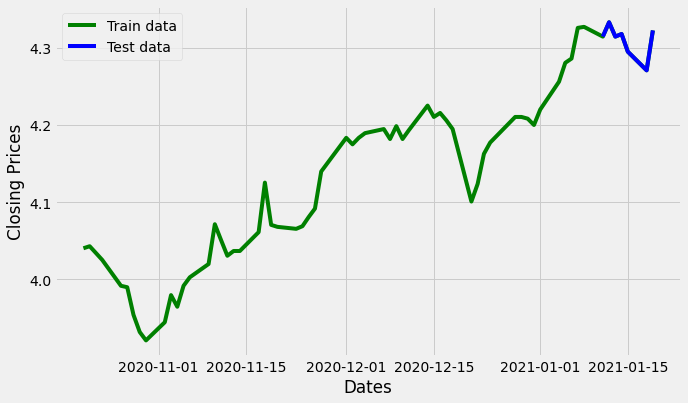

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-228.026, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-226.161, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-226.172, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-227.734, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-224.917, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.378 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 116.013
Date:                Wed, 20 Jan 2021   AIC                           -228.026
Time:                        09:58:03   BIC                           -224.086
Sample:                             0   HQIC                          -226.511
                                 - 54                                       

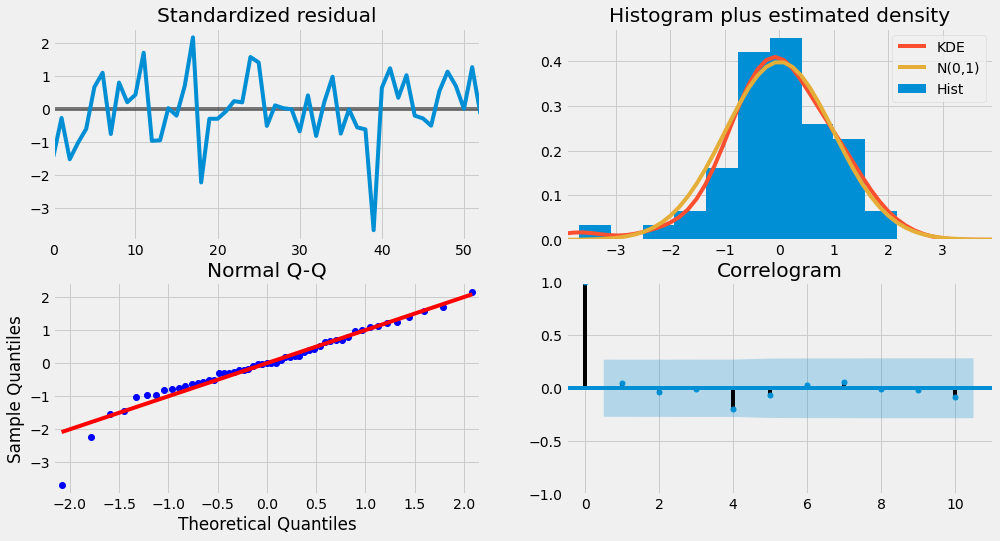

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                   53
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 118.133
Method:                       css-mle   S.D. of innovations              0.026
Date:                Wed, 20 Jan 2021   AIC                           -226.266
Time:                        09:58:24   BIC                           -216.415
Sample:                             1   HQIC                          -222.478
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0060      0.001      6.877      0.000       0.004       0.008
ar.L1.D.Close     0.7444      0.131      5.678      0.000       0.487       1.001
ma.L1.D.Close    -0.8240      0.175     

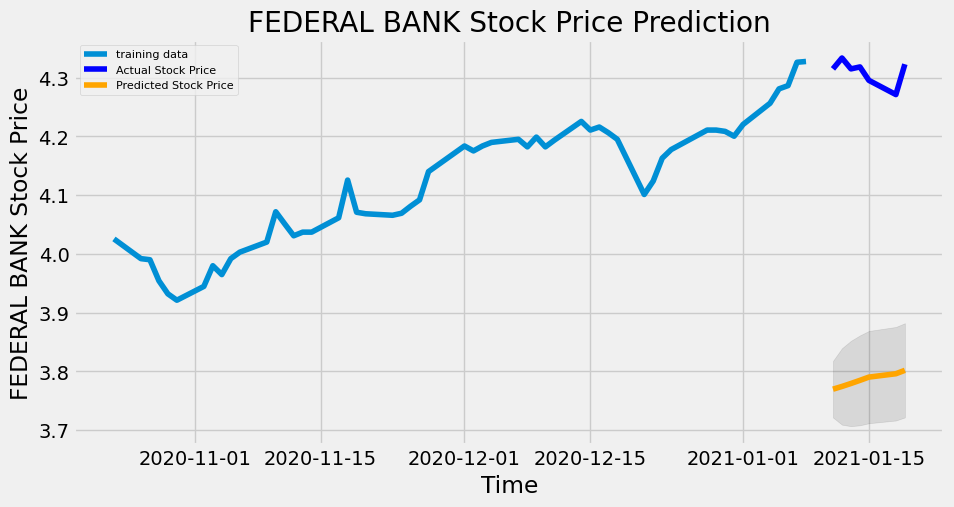

In [ ]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) 
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('FEDERAL BANK Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FEDERAL BANK Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.2763343118778851
MAE: 0.5250430383041553
RMSE: 0.5256751010632756
MAPE: 0.12179624686749659
